In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_ABOUT_rel_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5821097716948712 	 Validation loss: 0.42047002659005633 	 
  1%|          | 574/57400 [03:32<4:33:51,  3.46it/s]
Epoch 2 	 Training loss: 0.38993252632094594 	 Validation loss: 0.3595161826933845 	 
  2%|▏         | 1148/57400 [07:26<4:32:02,  3.45it/s]
Epoch 3 	 Training loss: 0.3524839850045247 	 Validation loss: 0.34089367723060865 	 
  3%|▎         | 1722/57400 [10:58<5:39:10,  2.74it/s]
Epoch 4 	 Training loss: 0.33367596665325894 	 Validation loss: 0.33276373981419255 	 
  4%|▍         | 2296/57400 [14:31<5:54:58,  2.59it/s]
Epoch 5 	 Training loss: 0.3208606389289534 	 Validation loss: 0.32550921808865113 	 
  5%|▌         | 2870/57400 [18:04<4:25:28,  3.42it/s]
Epoch 6 	 Training loss: 0.3079948750314812 	 Validation loss: 0.32035344662302634 	 
  6%|▌         | 3444/57400 [21:17<4:11:11,  3.58it/s]
Epoch 7 	 Training loss: 0.2980178309546115 	 Validation loss: 0.3155324216616356 	 
  7%|▋         | 4018/57400 [24:01<4:05:09,  3.63it/s]
Epoch 8 	 Trai

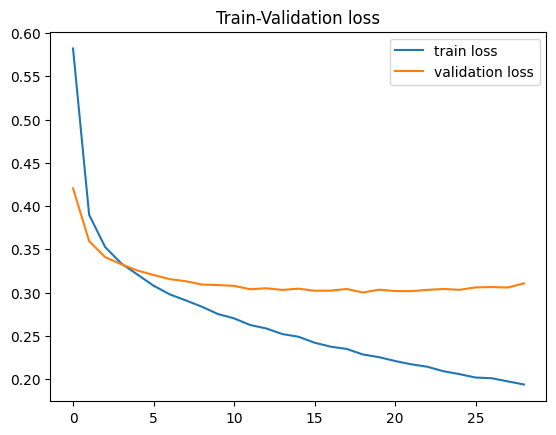

In [16]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8418367346938775
MALE 0.8489583333333334
FEMALE 0.835 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6679292929292929
MALE 0.6861313868613139
FEMALE 0.6482939632545932 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6779661016949152
MALE 0.6590909090909091
FEMALE 0.6981132075471698 



# TO

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_TO_rel_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6946208661856967 	 Validation loss: 0.6920786873768952 	 
  1%|          | 574/57400 [02:23<3:55:56,  4.01it/s]
Epoch 2 	 Training loss: 0.6939075130203459 	 Validation loss: 0.6914746508759967 	 
  2%|▏         | 1148/57400 [04:47<3:05:16,  5.06it/s]
Epoch 3 	 Training loss: 0.6937118923414874 	 Validation loss: 0.6928705512467077 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [07:11<3:43:57,  4.14it/s]
Epoch 4 	 Training loss: 0.6936622879854063 	 Validation loss: 0.6927373106196776 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [09:33<3:47:28,  4.04it/s]
Epoch 5 	 Training loss: 0.693388840462688 	 Validation loss: 0.6929126472796424 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [11:56<3:38:42,  4.16it/s]
Epoch 6 	 Training loss: 0.6933151757675596 	 Validation loss: 0.692772635969065 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [14:19<2:59:32,  5.01it/s]
Epoch 7 	 Training loss: 0.6931504071381864 	 V

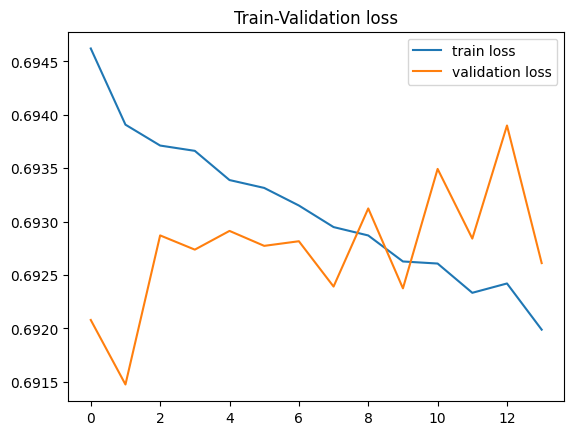

In [19]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5446428571428571
MALE 0.171875
FEMALE 0.9025 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5202020202020202
MALE 0.170316301703163
FEMALE 0.8976377952755905 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5097783572359843
MALE 0.16161616161616163
FEMALE 0.8814016172506739 



# AS

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_AS_rel_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694039647899023 	 Validation loss: 0.6921593789326943 	 
  1%|          | 574/57400 [02:23<3:54:46,  4.03it/s]
Epoch 2 	 Training loss: 0.6934541272784774 	 Validation loss: 0.6923001772266323 	 
  2%|▏         | 1148/57400 [04:46<3:45:17,  4.16it/s]
Epoch 3 	 Training loss: 0.6918729549916364 	 Validation loss: 0.6914399407677732 	 
  3%|▎         | 1722/57400 [07:09<3:57:20,  3.91it/s]
Epoch 4 	 Training loss: 0.6903744804111507 	 Validation loss: 0.691506527237973 	 
  4%|▍         | 2296/57400 [09:32<3:39:24,  4.19it/s]
Epoch 5 	 Training loss: 0.688973299613813 	 Validation loss: 0.6917802226745476 	 
  5%|▌         | 2870/57400 [11:55<3:49:43,  3.96it/s]
Epoch 6 	 Training loss: 0.6877871580447885 	 Validation loss: 0.6923495894771511 	 
  6%|▌         | 3444/57400 [14:19<2:54:12,  5.16it/s]
Epoch 7 	 Training loss: 0.6866113248602439 	 Validation loss: 0.6916165533712355 	 
  7%|▋         | 4018/57400 [16:42<2:53:13,  5.14it/s]
Epoch 8 	 Training loss:

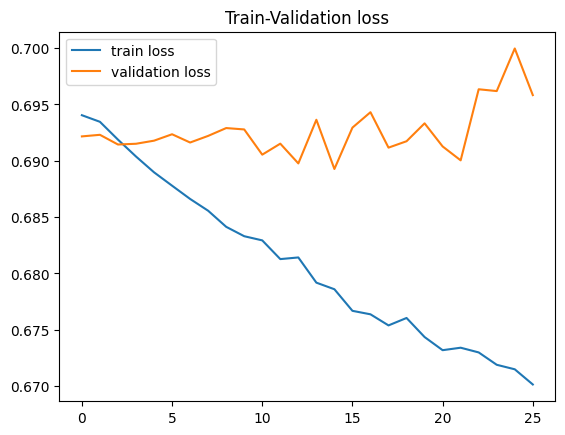

In [22]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6530612244897959
MALE 0.671875
FEMALE 0.635 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6691919191919192
MALE 0.6788321167883211
FEMALE 0.6587926509186351 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6949152542372882
MALE 0.6414141414141414
FEMALE 0.7520215633423181 

